In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Functions

In [2]:
def top_missing_cols(df,n=10,thresh=80):
    """
    returns missing columns in dataframe with missing values percent > thresh
    if n=None. It will gave whole dataframe with missing values percent > thresh
    """
    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['col','missing_percent']
    dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
    header('Missing Values Analysis:')
    print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
    print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
    if n:
        return dff.head(n)
    else:
        return dff
    
def header(text):
    """
    returns bolded text in blue
    """

    print(f"\033[94m\033[1m", text, f"\033[0m")

def num_nulls(df, perc=False) -> dict:
    """
    returns dictionary of column:nulls as key:value pairs
    if perc=True, then convert to % missing
    """

    nulls_dict = {}
    for col in df.columns:
        num_nulls = int(df[col].isnull().sum())
        if perc == True:
            nulls_dict[col] = (num_nulls / len(df[col])) * 100
        else:
            nulls_dict[col] = num_nulls
    return nulls_dict

def split_features(df, split_by):
    """
    splits a dataframe by column names
    returns 2 split sub-dataframes
    """

    others = df.drop(columns=split_by)
    split = df.loc[:, split_by]
    return split, others

def extract_df(df):
    '''
    returns numeric and categorical as 2 sub-dataframes
    '''

    num_cols = list(df.select_dtypes('number').columns)
    cat_cols = [j for j in df.columns if j not in num_cols]
    numeric, cat = split_features(df, split_by=num_cols)
    return numeric, cat

def preprocess_data(
        df,
        target:str,
        # remove_nulls_threshold:int,
        remove_nulls=False, 
        display_nulls=False,
        x_interpolate=False,
        standardise=False,
        ) -> pd.DataFrame:
    
    '''
    preprocessing wrapper;
    returns a cleaned dataframe based on settings
    '''
    
    # split independent & target:
    y, Xs = split_features(df, target)
    
    k = len(Xs.columns)
    
    # work on Y feature:
    if y.isnull().sum() > 0:
        y.interpolate(limit_area='inside')
        print('Target Feature has missing values being interpolated.')
    elif y.unique().sum() != 1:
        print('Target Feature is not binary.')
    else:
        y = pd.to_numeric(y)

    # remove any columns with constant values
    Xs = Xs[Xs.columns[Xs.nunique() > 1]]
    header('Number of Columns with constant values dropped:') 
    print(f'{k - len(Xs.columns)}')

    # replace any non-NaN missing values with NaN
    Xs = Xs.replace([float('inf'), float('-inf'), None, 'NULL', 'Null', 'null'], float('nan'))
    
    if x_interpolate is True:
        Xs = Xs.interpolate(limit_area='inside')
        header(f'Features with missing values interpolated.')
        
    # remove any columns that have > x null values
    if remove_nulls is True:
        # null_dict = num_nulls(Xs, perc=True)
        # nullcols = [i for i in null_dict.keys() if null_dict[i] >= remove_nulls_threshold]
        # Xs = Xs.loc[:, [c for c in Xs.columns if c not in nullcols]]
        # header('Number of Columns with > 50% NaN droped:')
        # print(f'{len(nullcols)}')
        df_missing_values = top_missing_cols(Xs, thresh = 90)
        cols_to_drop = df_missing_values['col'].unique()
        Xs.drop(columns = cols_to_drop, inplace = True)

    if display_nulls is True:
        print('Top columns with missing values being dropped:\n')
        display(df_missing_values)
        # display(pd.DataFrame(list(null_dict.items()), columns=['Feature', 'Percentage_Null']) \
        #         .set_index('Feature') \
        #         .sort_values(by='Percentage_Null', ascending=False) \
        #         .head(10))

    # standardise numerical columns
    if standardise is True:
        z = StandardScaler()
        num, cat = extract_df(Xs)
        for col in num:
            Xs[col] = Xs[col] if col == 'TransactionID' else z.fit_transform(Xs[col].to_numpy().reshape(-1, 1))

    # encode any bool columns and any strings labelled T/F to 1/0
    Xs[Xs.columns[Xs.dtypes == 'bool']] += 0
    for x in Xs.columns:
        if ('T' in set(Xs[x])) or ('F' in set(Xs[x])):
            Xs[x] = Xs[x].replace('T', 1).replace('F', 0)

    # rejoin Xs and Y features
    newdf = pd.concat([Xs, y], axis=1)

    return newdf

In [3]:
#os.chdir('/Users/chowshengyang/Documents/BT4222_Fraud_Detection_CRWKIJ/datasets')
# transaction_train = pd.read_csv('train_transaction.csv')

# df1 = pd.read_csv('/Users/remuslum/Downloads/ieee-fraud-detection/train_transaction.csv')
# df2 = pd.read_csv('/Users/remuslum/Downloads/ieee-fraud-detection/train_identity.csv')

fn1, fn2 = 'train_transaction.csv', 'train_identity.csv'
df1 = pd.read_csv('/Users/chowshengyang/Desktop/BT4222_Group_Project/data/'+fn1)
df2 = pd.read_csv('/Users/chowshengyang/Desktop/BT4222_Group_Project/data/'+fn2)

df_train = df1.merge(df2, on = 'TransactionID', how = 'left')

In [4]:
header('Initial Training Data:')
df_train.head()

 Initial Training Data: 


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


# Preprocessing

In [5]:
# def top_missing_cols(df,n=10,thresh=80):
#     """
#     returns missing columns in dataframe with missing values percent > thresh
#     if n=None. It will gave whole dataframe with missing values percent > thresh
#     """
    
#     dff = (df.isnull().sum()/df.shape[0])*100
#     dff = dff.reset_index()
#     dff.columns = ['col','missing_percent']
#     dff = dff.sort_values(by=['missing_percent'],ascending=False).reset_index(drop=True)
#     print(f'There are {df.isnull().any().sum()} columns in this dataset with missing values.')
#     print(f'There are {dff[dff["missing_percent"] > thresh].shape[0]} columns with missing percent values than {thresh}%')
#     if n:
#         return dff.head(n)
#     else:
#         return dff

df_train = preprocess_data(df=df_train,
                            target='isFraud',
                            remove_nulls=True,
                            # remove_nulls_threshold=None,
                            display_nulls=True,
                            x_interpolate=False,
                            standardise=False)

header('Preprocessed Training Data:')
df_train.head()

 Number of Columns with constant values dropped: 
0
 Missing Values Analysis: 
There are 414 columns in this dataset with missing values.
There are 12 columns with missing percent values than 90%
Top columns with missing values being dropped:



,col,missing_percent
0,id_24,99.196159
1,id_25,99.130965
2,id_08,99.127070
3,id_07,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


 Preprocessed Training Data: 


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,32.0,2220x1080,match_status:2,1.0,0.0,1.0,1.0,mobile,SAMSUNG SM-G892A Build/NRD90M,0


In [6]:
# df_missing_values = top_missing_cols(df_train, thresh = 90)

In [7]:
# df_missing_values


In [8]:
# cols_to_drop = df_missing_values['col'].unique()

In [9]:
# df_train.drop(columns = cols_to_drop, inplace = True)
# df_train.head()

# Add Day of Week and Hour

 Visualise Frauds based on Days: 


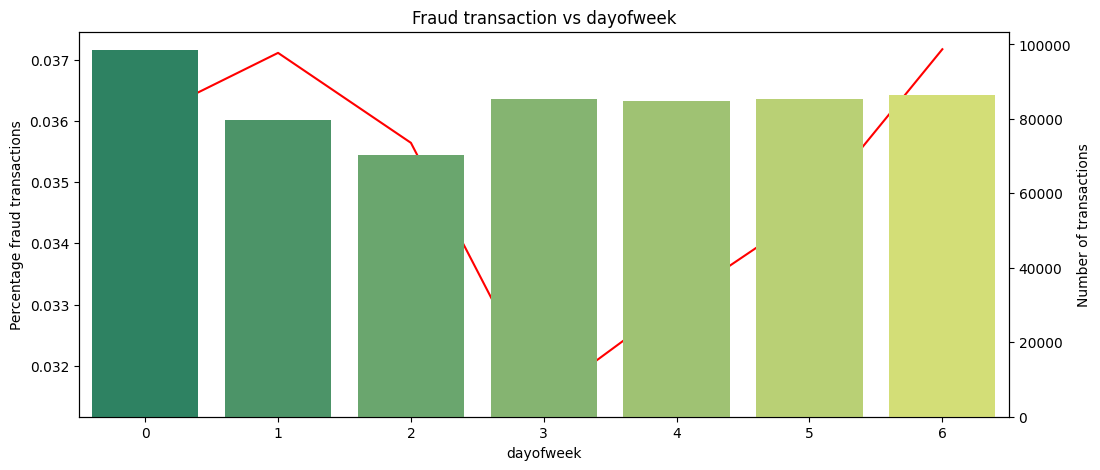

In [10]:
df_train['dayofweek'] = (df_train['TransactionDT']//(60*60*24)-1)%7
tmp = df_train[['isFraud','dayofweek']].groupby(by=['dayofweek']).mean().reset_index() \
            .rename(columns={'isFraud':'Percentage fraud transactions'})

tmp_count = df_train[['TransactionID','dayofweek']].groupby(by=['dayofweek']).count().reset_index() \
            .rename(columns={'TransactionID':'Number of transactions'})
tmp = tmp.merge(tmp_count,on=['dayofweek'])

header('Visualise Frauds based on Days:')
fig, axes = plt.subplots(figsize=(12,5))
axes = sns.lineplot(x=tmp['dayofweek'],y=tmp['Percentage fraud transactions'],color='r')
axes2 = axes.twinx()
axes2 = sns.barplot(x=tmp['dayofweek'],y=tmp['Number of transactions'],palette='summer')
axes.set_title('Fraud transaction vs dayofweek')
plt.show()

 Visualise Frauds based on Hours: 


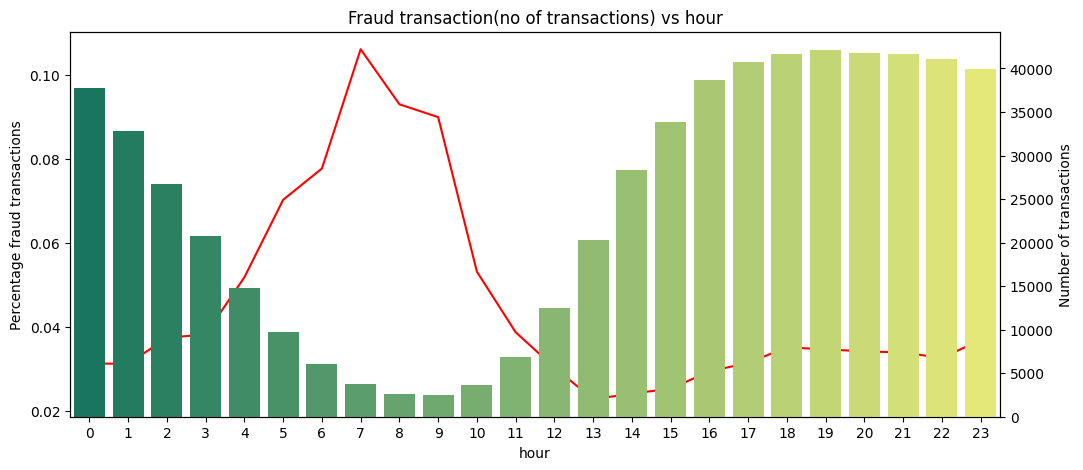

In [11]:
df_train['hour'] = (df_train['TransactionDT']//(60*60))%24
tmp = df_train[['isFraud','hour']].groupby(by=['hour']).mean().reset_index() \
            .rename(columns={'isFraud':'Percentage fraud transactions'})

tmp_count = df_train[['TransactionID','hour']].groupby(by=['hour']).count().reset_index() \
            .rename(columns={'TransactionID':'Number of transactions'})
tmp = tmp.merge(tmp_count,on=['hour'])

header('Visualise Frauds based on Hours:')
fig, axes = plt.subplots(figsize=(12,5))
axes = sns.lineplot(x=tmp['hour'],y=tmp['Percentage fraud transactions'],color='r')
axes2 = axes.twinx()
axes2 = sns.barplot(x=tmp['hour'],y=tmp['Number of transactions'],palette='summer')
axes.set_title('Fraud transaction(no of transactions) vs hour')
plt.show()

In [12]:
# def header(text):
#     print(f"\033[94m\033[1m", text, f"\033[0m")

# def num_nulls(df, perc=False) -> dict:
#     nulls_dict = {}
#     for col in df.columns:
#         num_nulls = int(df[col].isnull().sum())
#         if perc == True:
#             nulls_dict[col] = (num_nulls / len(df[col])) * 100
#         else:
#             nulls_dict[col] = num_nulls
#     return nulls_dict

# def split_features(df, split_by):
#     others = df.drop(columns=split_by)
#     split = df.loc[:, split_by]
#     return split, others

# def extract_df(df):
#     num_cols = list(df.select_dtypes('number').columns)
#     cat_cols = [j for j in df.columns if j not in num_cols]
#     numeric, cat = split_features(df, split_by=num_cols)
#     return numeric, cat

# def preprocess_data(
#         df,
#         target:str,
#         remove_nulls_threshold:int,
#         remove_nulls=False, 
#         display_nulls=False,
#         interpolate=False,
#         standardise=False,
#         ) -> pd.DataFrame:
    
#     # split independent & target:
#     y, Xs = split_features(df, target)
    
#     k = len(Xs.columns)
    
#     # work on Y feature:
#     if y.isnull().sum() > 0:
#         y.interpolate(limit_area='inside')
#         print('Target Feature has missing values being interpolated.')
#     elif y.unique().sum() != 1:
#         print('Target Feature is not binary.')
#     else:
#         y = pd.to_numeric(y)

#     # remove any columns with constant values
#     Xs = Xs[Xs.columns[Xs.nunique() > 1]]
#     header('Number of Columns with constant values dropped:') 
#     print(f'{k - len(Xs.columns)}')

#     # replace any non-NaN missing values with NaN
#     Xs = Xs.replace([float('inf'), float('-inf'), None, 'NULL', 'Null', 'null'], float('nan'))
    
#     if interpolate is True:
#         Xs = Xs.interpolate(limit_area='inside')
#         header(f'Features with missing values interpolated.')
        
#     # remove any columns that have > x null values
#     if remove_nulls is True:
#         null_dict = num_nulls(Xs, perc=True)
#         nullcols = [i for i in null_dict.keys() if null_dict[i] >= remove_nulls_threshold]
#         Xs = Xs.loc[:, [c for c in Xs.columns if c not in nullcols]]
#         header('Number of Columns with > 50% NaN droped:')
#         print(f'{len(nullcols)}')

#     if display_nulls is True:
#         display(pd.DataFrame(list(null_dict.items()), columns=['Feature', 'Percentage_Null']) \
#                 .set_index('Feature') \
#                 .sort_values(by='Percentage_Null', ascending=False) \
#                 .head(10))

#     # standardise numerical columns
#     if standardise is True:
#         z = StandardScaler()
#         num, cat = extract_df(Xs)
#         for col in num:
#             Xs[col] = Xs[col] if col == 'TransactionID' else z.fit_transform(Xs[col].to_numpy().reshape(-1, 1))

#     # encode any bool columns and any strings labelled T/F to 1/0
#     Xs[Xs.columns[Xs.dtypes == 'bool']] += 0
#     for x in Xs.columns:
#         if ('T' in set(Xs[x])) or ('F' in set(Xs[x])):
#             Xs[x] = Xs[x].replace('T', 1).replace('F', 0)

#     # rejoin Xs and Y features
#     newdf = pd.concat([Xs, y], axis=1)

#     return newdf

# Add Log Transaction Amount

 Visualise log_TransactionAmt: 


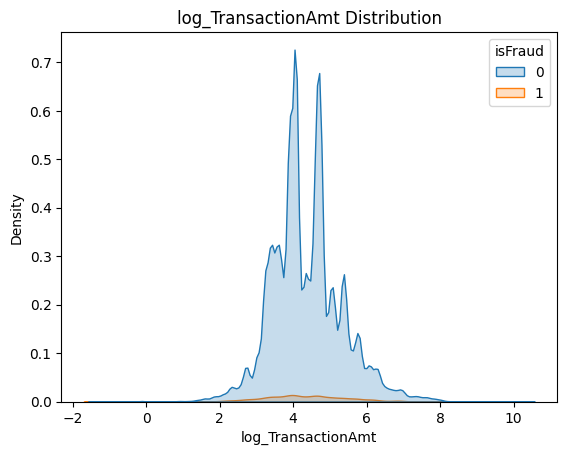

In [13]:
df_train['log_TransactionAmt'] = np.log(df_train['TransactionAmt'])

# EDA on _log_TransactionAmt:
header('Visualise log_TransactionAmt:')
sns.kdeplot(data=df_train, 
            x='log_TransactionAmt', hue='isFraud',
            multiple='layer',
            fill=True)

plt.title('log_TransactionAmt Distribution')
plt.show()

In [14]:
# df_train = preprocess_data(df=df_train,
#                             target='isFraud',
#                             remove_nulls=False,
#                             remove_nulls_threshold=None,
#                             display_nulls=False,
#                             x_interpolate=False,
#                             standardise=False)

# header('Preprocessed Training Data:')
# display(df_train)

# VISUALIZATION

 Datatypes of each Feature: 
{dtype('float64'), dtype('O'), dtype('int64')}
 Visualise _isFraud: 


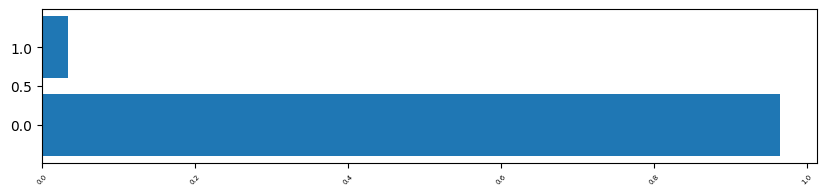

In [15]:
fs=(10, 2)
fraud_cond, no_fraud_cond = df_train['isFraud'] == 1, df_train['isFraud'] == 0
bar_width = 0.35

# datatypes of each feature:
header("Datatypes of each Feature:")
print(set(df_train.dtypes))

# EDA on _isFraud:
header('Visualise _isFraud:')
plt.figure(figsize=fs)
isfraud = df_train.isFraud.value_counts(normalize=True).to_dict()
plt.barh(list(isfraud.keys()), list(isfraud.values()))
plt.xticks(rotation=45, fontsize=5)
plt.show()

# # EDA on _TransactionAmt:
# header('Visualise _TransactionAmt:')
# # fraud_cond, no_fraud_cond = df_train['isFraud'] == 1, df_train['isFraud'] == 0
# T_Amt_Fraud = df_train[fraud_cond]['TransactionAmt'].to_numpy()
# T_Amt_NoFraud = df_train[no_fraud_cond]['TransactionAmt'].to_numpy()

# fig, axs = plt.subplots(1, 2, figsize=fs, tight_layout=True)

# axs[0].boxplot(T_Amt_Fraud, vert=False)
# axs[0].set_title(f'max_amount: {max(T_Amt_Fraud)}\nmin_amount: {min(T_Amt_Fraud)}')
# axs[1].boxplot(T_Amt_NoFraud, vert=False)
# axs[1].set_title(f'max_amount: {max(T_Amt_NoFraud)}\nmin_amount: {min(T_Amt_NoFraud)}')

# plt.show()

# del fig, axs

# # EDA on _log_TransactionAmt:
# header('Visualise log_TransactionAmt:')
# sns.kdeplot(data=df_train, 
#             x='log_TransactionAmt', hue='isFraud',
#             multiple='layer',
#             fill=True)

# plt.title('log_TransactionAmt Distribution')
# plt.show()

# EDA on _ProductCD:
# header('Visualise _ProductCD:')

# bar_width = 0.35
# x = np.arange(len(set(df_train['ProductCD'])))
# fig, ax = plt.subplots()

# CD_Fraud = df_train[fraud_cond]['ProductCD'].value_counts(normalize=True, dropna=False)
# bar1 = ax.bar(x - bar_width/2, CD_Fraud, bar_width, label='Fraud')
# CD_NoFraud = df_train[no_fraud_cond]['ProductCD'].value_counts(normalize=True, dropna=False)
# bar2 = ax.bar(x + bar_width/2, CD_NoFraud, bar_width, label='No Fraud')

# ax.set_xlabel('ProductCD')
# ax.set_ylabel('% Count')
# ax.set_title('ProductCD Distribution')
# ax.set_xticks(x)
# ax.set_xticklabels(df_train['ProductCD'].value_counts().keys())
# ax.legend()

# plt.show()

# del fig, ax, x, bar1, bar2

# EDA on _card4:
# header('Visualise _card4:')

# x = np.arange(len(set(df_train['card4'])))
# fig, ax = plt.subplots()

# # Plot the bars for Class 1
# card4_Fraud = df_train[fraud_cond]['card4'].value_counts(normalize=True, dropna=False)
# bar1 = ax.bar(x - bar_width/2, card4_Fraud, bar_width, label='Fraud', color='steelblue')
# # Plot the bars for Class 2
# card4_NoFraud = df_train[no_fraud_cond]['card4'].value_counts(normalize=True, dropna=False)
# bar2 = ax.bar(x + bar_width/2, card4_NoFraud, bar_width, label='No Fraud', color='skyblue')

# ax.set_xlabel('card4')
# ax.set_ylabel('% Count')
# ax.set_title('card4 Distribution')
# ax.set_xticks(x)
# ax.set_xticklabels(df_train['card4'].value_counts(normalize=True, dropna=False).keys(),
#                    rotation=45)
# ax.legend()

# plt.show()

# del fig, ax


# Visualize Card 4:

 Visualise _card4: 


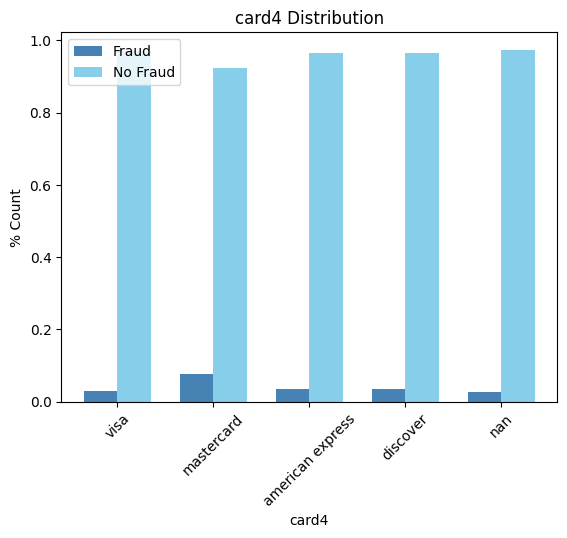

In [16]:
header('Visualise _card4:')

x = np.arange(len(set(df_train['card4'])))
fig, ax = plt.subplots()

card4 = df_train.groupby(['card4','isFraud'], dropna=False)\
        .apply(lambda x: x.shape[0]) \
        .groupby(level=0, dropna=False) \
        .apply(lambda x: x/x.sum())

card4_nofraud = [card4[i] for i in range(0, card4.shape[0], 2)]
card4_fraud = [card4[i] for i in range(1, card4.shape[0], 2)]

# Plot the bars for Class 1
bar1 = ax.bar(x - bar_width/2, card4_fraud, bar_width, label='Fraud', color='steelblue')
# Plot the bars for Class 2
bar2 = ax.bar(x + bar_width/2, card4_nofraud, bar_width, label='No Fraud', color='skyblue')

ax.set_xlabel('card4')
ax.set_ylabel('% Count')
ax.set_title('card4 Distribution')
ax.set_xticks(x)
ax.set_xticklabels(df_train['card4'].value_counts(normalize=True, dropna=False).keys(),
                   rotation=45)
ax.legend()
plt.show()

del fig, ax, x

# Visualize Product CD:

 Visualise _ProductCD: 


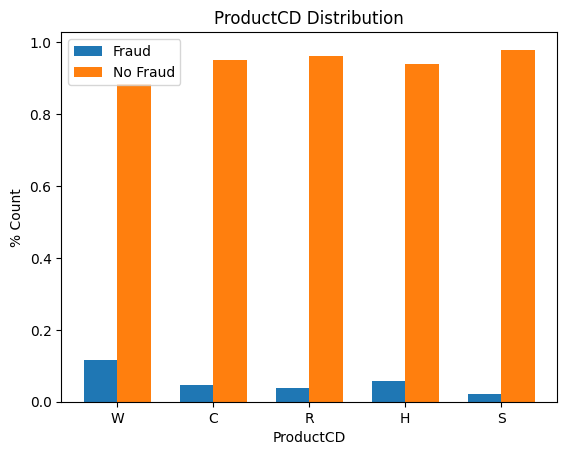

In [17]:
header('Visualise _ProductCD:')
x = np.arange(len(set(df_train['ProductCD'])))
fig, ax = plt.subplots()

cd = df_train.groupby(['ProductCD','isFraud'], dropna=False)\
        .apply(lambda x: x.shape[0]) \
        .groupby(level=0, dropna=False) \
        .apply(lambda x: x/x.sum())

cd_nofraud = [cd[i] for i in range(0, cd.shape[0], 2)]
cd_fraud = [cd[i] for i in range(1, cd.shape[0], 2)]

bar1 = ax.bar(x - bar_width/2, cd_fraud, bar_width, label='Fraud')
CD_NoFraud = df_train[no_fraud_cond]['ProductCD'].value_counts(normalize=True, dropna=False)
bar2 = ax.bar(x + bar_width/2, cd_nofraud, bar_width, label='No Fraud')

ax.set_xlabel('ProductCD')
ax.set_ylabel('% Count')
ax.set_title('ProductCD Distribution')
ax.set_xticks(x)
ax.set_xticklabels(df_train['ProductCD'].value_counts().keys())
ax.legend()
plt.show()

del fig, ax, x

In [38]:
df_train.isna()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,isFraud,dayofweek,hour,log_TransactionAmt
0,False,False,False,False,False,True,False,False,False,False,...,True,True,True,True,True,True,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,False,False,False,False,False,True,False,False,False,False,...,True,True,True,True,True,True,False,False,False,False
590536,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,False,False,False,False
590537,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,False,False,False,False
590538,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,False,False,False,False
